# German Credit Probability of Default Model

This project focuses on developing a credit scorecard model to assess an individual's creditworthiness (good/bad credit) based on financial features such as credit history, purpose, and savings. The model utilizes Weight of Evidence (WoE) and Information Value (IV) to transform categorical and numerical features into meaningful predictive variables, followed by logistic regression for credit risk assessment.

The scorecard is designed to provide an interpretable and data-driven approach to credit scoring, which can be used in financial lending and risk evaluation.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve

In [8]:
# Load dataset
df = pd.read_csv("german_credit_data.csv")  # Update with actual file path

## Data Preparation

In [9]:
# Mapping German Column Names to English

column_mapping = {
    'laufkont': 'Status',               # Categorical (Ordinal)
    'laufzeit': 'Duration',             # Numerical
    'moral': 'Credit History',          # Categorical (Nominal)
    'verw': 'Purpose',                  # Categorical (Nominal)
    'hoehe': 'Amount',                  # Numerical
    'sparkont': 'Savings',              # Categorical (Ordinal)
    'beszeit': 'Employment Duration',   # Categorical (Ordinal)
    'rate': 'Installment Rate',         # Categorical (Ordinal)
    'famges': 'Personal Status Sex',    # Categorical (Nominal)
    'buerge': 'Other Debtors',          # Categorical (Nominal)
    'wohnzeit': 'Present Residence',    # Categorical (Ordinal)
    'verm': 'Property',                 # Categorical (Nominal)
    'alter': 'Age',                     # Numerical
    'weitkred': 'Other Installment Plans',  # Categorical (Nominal)
    'wohn': 'Housing',                  # Categorical (Nominal)
    'bishkred': 'Number Credits',       # Categorical (Ordinal)
    'beruf': 'Job',                     # Categorical (Nominal)
    'pers': 'People Liable',            # Categorical (Ordinal)
    'telef': 'Telephone',               # Categorical (Nominal)
    'gastarb': 'Foreign Worker',        # Categorical (Nominal)
    'kredit': 'Credit Risk'             # Binary Target Variable
}

# Rename columns to English
df.rename(columns=column_mapping, inplace=True)

# Drop missing values (alternatively, use df.fillna() for imputation)
df = df.dropna()

Cleans and structures raw credit data for modeling.

## Feature Engineering

Converts raw features into WoE values that quantify risk.

In [10]:
# ---- 3. Define Feature Groups ----
nominal_cols = ['Credit History', 'Purpose', 'Personal Status Sex', 'Other Debtors', 
                'Property', 'Other Installment Plans', 'Housing', 'Job', 'People Liable', 
                'Telephone', 'Foreign Worker']

ordinal_cols = ['Status', 'Savings', 'Employment Duration', 'Installment Rate', 
                'Present Residence', 'Number Credits']

numerical_cols = ['Duration', 'Amount', 'Age']

# Encode Nominal Features using LabelEncoder
le = LabelEncoder()
for col in nominal_cols:
    df[col] = le.fit_transform(df[col])

# Encode Ordinal Features
ordinal_enc = OrdinalEncoder()
df[ordinal_cols] = ordinal_enc.fit_transform(df[ordinal_cols])

# Scale Numerical Features using StandardScaler
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

## Modeling Pipeline

In [11]:
X = df.drop(columns=["Credit Risk"])  # Features
y = df["Credit Risk"]  # Target (0 = Good Credit, 1 = Bad Credit)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predictions
y_probs = log_reg.predict_proba(X_test)[:, 1]  # Probability of default
y_pred = (y_probs > 0.5).astype(int)  # Default threshold at 50%


AUC-ROC: 0.793

Confusion Matrix:
 [[ 28  34]
 [ 15 123]]

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.45      0.53        62
           1       0.78      0.89      0.83       138

    accuracy                           0.76       200
   macro avg       0.72      0.67      0.68       200
weighted avg       0.74      0.76      0.74       200



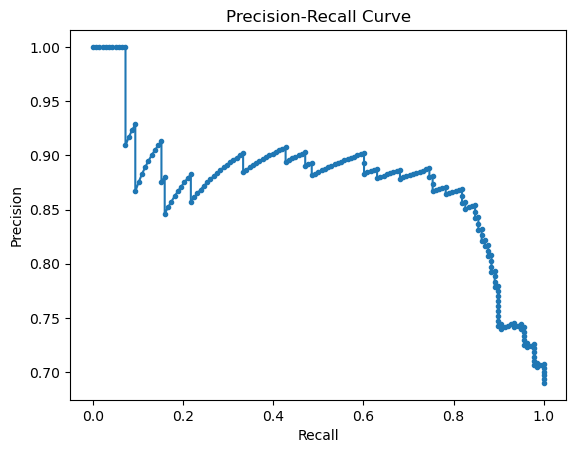

In [14]:
# Evaluation
auc_roc = roc_auc_score(y_test, y_probs)
print(f"AUC-ROC: {auc_roc:.3f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
plt.plot(recall, precision, marker='.')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

## Credit Scorecard: Probability of Default (PD)

Assigns customers into risk bands based on their probability of default. This summarizes default risk by score band (e.g., how many customers fall into each risk category).

In [13]:
df_test = X_test.copy()
df_test["PD_Score"] = y_probs

# Assign score bands
df_test["Score_Band"] = pd.qcut(df_test["PD_Score"], q=5, labels=["Very Low", "Low", "Medium", "High", "Very High"])

# Show default rates by score band
scorecard_summary = df_test.groupby("Score_Band")["PD_Score"].agg(["count", "mean"]).rename(columns={"mean": "Default_Rate"})
print("\n🏁 Final Credit Scorecard Summary:\n", scorecard_summary)


🏁 Final Credit Scorecard Summary:
             count  Default_Rate
Score_Band                     
Very Low       40      0.324890
Low            40      0.607165
Medium         40      0.779966
High           40      0.874971
Very High      40      0.949239


C:\Users\milto\AppData\Local\Temp\ipykernel_7004\1516432068.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  scorecard_summary = df_test.groupby("Score_Band")["PD_Score"].agg(["count", "mean"]).rename(columns={"mean": "Default_Rate"})


### Key Takeaways

- Model performs well in identifying bad credit cases (recall = 89%), meaning it catches most defaulters.
- But it struggles with good credit cases (recall = 45%), meaning many creditworthy customers are wrongly flagged as bad (False Positives).
- Overall accuracy is 76%, which is decent but not perfect.
- AUC-ROC (0.793) indicates a good ability to distinguish between good & bad credit.

## Conclusion

In this project, I developed a binary classification model to predict creditworthiness (good/bad credit) using a dataset containing information about customers' credit history and default behavior. The model leveraged key financial indicators such as credit utilization, monthly income, and loan amount to assess the likelihood of default.

### Future Improvements

To enhance the model’s performance, I can:

- Fine-tune the classification threshold to reduce false positives (good customers misclassified as bad).
- Explore alternative machine learning models (e.g., Random Forest, XGBoost) to improve precision and recall.
- Perform feature engineering to better capture financial patterns affecting credit risk.